In [1]:
%pip install numpy pandas scikit-learn matplotlib seaborn yfinance


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
import yfinance as yf
import pandas as pd
import numpy as np



# Download stock data (choose your ticker of interest)
ticker = 'AAPL'  # You can change this to any other asset like 'BTC-USD', 'SPY', etc.
#data = yf.download(ticker, start="2018-01-01", end="2023-01-01", interval='1d')
data = yf.Ticker('BTC-USD').history(period="max", interval="1h")
# Inspect the data
data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-10-15 14:00:00+00:00,19165.728516,19174.300781,19138.466797,19150.951172,0,0.0,0.0
2022-10-15 15:00:00+00:00,19150.736328,19151.000000,19134.281250,19142.769531,0,0.0,0.0
2022-10-15 16:00:00+00:00,19139.406250,19160.175781,19127.302734,19129.800781,0,0.0,0.0
2022-10-15 17:00:00+00:00,19130.179688,19136.921875,19108.720703,19110.136719,0,0.0,0.0
2022-10-15 18:00:00+00:00,19110.664062,19132.585938,19110.664062,19126.982422,0,0.0,0.0


In [27]:
# Feature Engineering
data['O-C'] = data['Open'] - data['Close']
data['H-L'] = data['High'] - data['Low']
data['Momentum'] = data['Close'] - data['Close'].shift(5)
data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Simple Moving Average (SMA)
data['SMA_10'] = data['Close'].rolling(window=10).mean()

# Exponential Moving Average (EMA)
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()

# Lagged Returns (Past returns)
data['Lag_1'] = data['Returns'].shift(1)
data['Lag_2'] = data['Returns'].shift(2)

# Label the data: 1 for positive move, 0 for negative move
threshold = 0.0025  # e.g., 0.25% can be the threshold for binomial classification
data['Target'] = np.where(data['Returns'] > threshold, 1, 0)

# Drop rows with NaN values (due to lagged or rolling operations)
data = data.dropna()

data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,O-C,H-L,Momentum,Returns,SMA_10,EMA_10,Lag_1,Lag_2,Target
Datetime,,,,,,,,,,,,,,,,
2022-10-15 23:00:00+00:00,19075.621094,19116.964844,19019.250000,19065.828125,406720512,0.0,0.0,9.792969,97.714844,-61.154297,-0.000634,19108.833594,19101.982023,-0.000019,-0.001275,0
2022-10-16 00:00:00+00:00,19069.291016,19132.908203,19069.291016,19132.908203,33409024,0.0,0.0,-63.617188,63.617188,29.849609,0.003512,19107.029297,19107.604965,-0.000634,-0.000019,1
2022-10-16 01:00:00+00:00,19134.605469,19153.160156,19118.015625,19146.425781,2835456,0.0,0.0,-11.820312,35.144531,43.808594,0.000706,19107.394922,19114.663295,0.003512,-0.000634,0
2022-10-16 02:00:00+00:00,19145.199219,19154.646484,19120.404297,19120.404297,0,0.0,0.0,24.794922,34.242188,42.130859,-0.001360,19106.455273,19115.707114,0.000706,0.003512,0
2022-10-16 03:00:00+00:00,19118.808594,19133.166016,19118.066406,19126.820312,0,0.0,0.0,-8.011719,15.099609,48.902344,0.000336,19108.123633,19117.727695,-0.001360,0.000706,0


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target
features = ['O-C', 'H-L', 'Momentum', 'SMA_10', 'EMA_10', 'Lag_1', 'Lag_2']
X = data[features]
y = data['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Create the SVM model with default parameters
svm = SVC(probability=True)

# Fit the model
svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm.predict(X_test_scaled)
y_proba = svm.predict_proba(X_test_scaled)[:, 1]


In [30]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Grid search with cross-validation
grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train_scaled, y_train)

# Best model
best_svm = grid.best_estimator_

# Evaluate the best model
y_pred_best = best_svm.predict(X_test_scaled)
y_proba_best = best_svm.predict_proba(X_test_scaled)[:, 1]


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.3s
[CV] END .......................C=0.1, gamma=0.

Confusion Matrix:
[[4133   32]
 [  69  994]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4165
           1       0.97      0.94      0.95      1063

    accuracy                           0.98      5228
   macro avg       0.98      0.96      0.97      5228
weighted avg       0.98      0.98      0.98      5228


ROC AUC Score: 0.9955940231219487


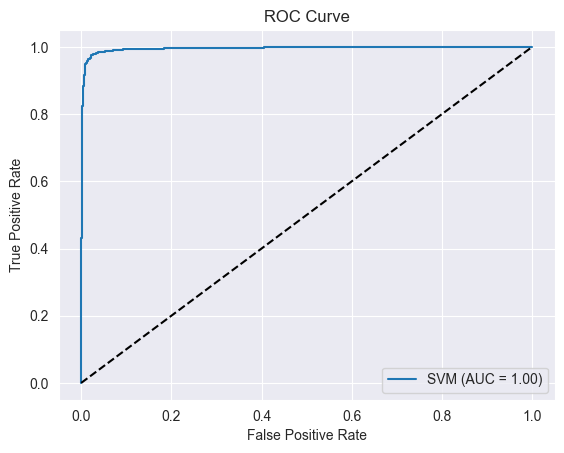

In [31]:
# Confusion Matrix and Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba_best)
print("\nROC AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()
